## HW2
Name: Pei Tian (pt2632)


### GCP VM Configuration
- Machine Type: g2-standard-4 (4 vCPUs, 16 GB Memory)
- Disk: 50GB
- CPU: Intel Cascade Lake
- GPU: 1 x NVIDIA L4
- OS: Deep Learning Image:  Deep Learning VM with CUDA 12.1 M126 (Debian)

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse_log(file_path):
    with open(file_path, 'r') as file:
        log_text = file.read()
    # Regex to find relevant information
    worker_pattern = re.compile(r'Created DataLoader with batch size \d+ and (\d+) workers')
    epoch_pattern = re.compile(r'Epoch (\d+):.*?100%')
    time_pattern = re.compile(r'elapsed: ([\d\.]+)s, dataload: ([\d\.]+)s, training: ([\d\.]+)s')
    metric_pattern = re.compile(r'per-batch loss:  ([\d\.]+), top1 accuracy: ([\d\.]+)')
    batch_norm_pattern = re.compile(r'BatchNorm: (\w+)')
    optimizer_pattern = re.compile(r'Using (\w+) optimizer')
    compilation_mode_pattern = re.compile(r'Compile Mode: ([\w\s-]+)')
    device_pattern = re.compile(r'Using device: (\w+)')

    # Prepare to collect parsed data
    data = []

    # Extract sections for each worker setting
    worker_counts = worker_pattern.findall(log_text)
    sections = log_text.split("Done\n")

    # Loop through each section
    for section, worker_count in zip(sections, worker_counts):
        epochs = epoch_pattern.findall(section)
        times = time_pattern.findall(section)
        metrics = metric_pattern.findall(section)
        batch_norm = batch_norm_pattern.search(section).group(1)
        batch_norm = True if batch_norm == 'True' else False
        optimizer = optimizer_pattern.search(section).group(1)
        compilation_mode = compilation_mode_pattern.search(section).group(1)
        device = device_pattern.search(section).group(1)
        for epoch, (elapsed, dataload, training), (loss, accuracy) in zip(epochs, times, metrics):
            data.append({
                'Worker': int(worker_count),
                'Epoch': int(epoch),
                'Total Elapsed Time (s)': float(elapsed),
                'Data Load Time (s)': float(dataload),
                'Training Time (s)': float(training),
                'Per-Batch Loss': float(loss),
                'Top1 Accuracy': float(accuracy),
                'Batch Normalization': batch_norm,
                'Optimizer': optimizer,
                'Compilation Mode': compilation_mode,
                'Device': device
                
            })

    # Convert data to DataFrame
    return pd.DataFrame(data)

### C2: Time Measurement for Code in C1
<img src="img/C2.png" align="center"/>

In [3]:
df2 = parse_log("C2.log")
df2.shape

(5, 11)

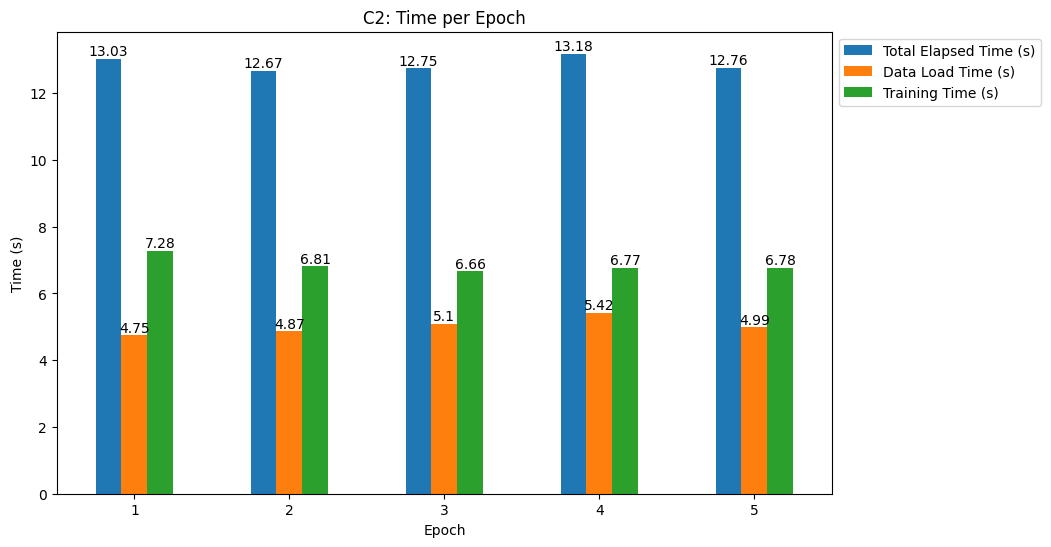

In [4]:
ax = df2.groupby("Epoch")[[ "Total Elapsed Time (s)", "Data Load Time (s)", "Training Time (s)"]].mean()\
    .plot(kind='bar', title="C2: Time per Epoch", figsize=(10, 6))
plt.ylabel("Time (s)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')
plt.show()

### C3: I/O optimization for code in C2

<img src="img/C3-1.png" align="center"/>
<img src="img/C3-2.png" align="center"/>
<img src="img/C3-3.png" align="center"/>
<img src="img/C3-4.png" align="center"/>
<img src="img/C3-5.png" align="center"/>
<img src="img/C3-6.png" align="center"/>

In [5]:
df3 = parse_log("C3.log")
df3.shape

(30, 11)

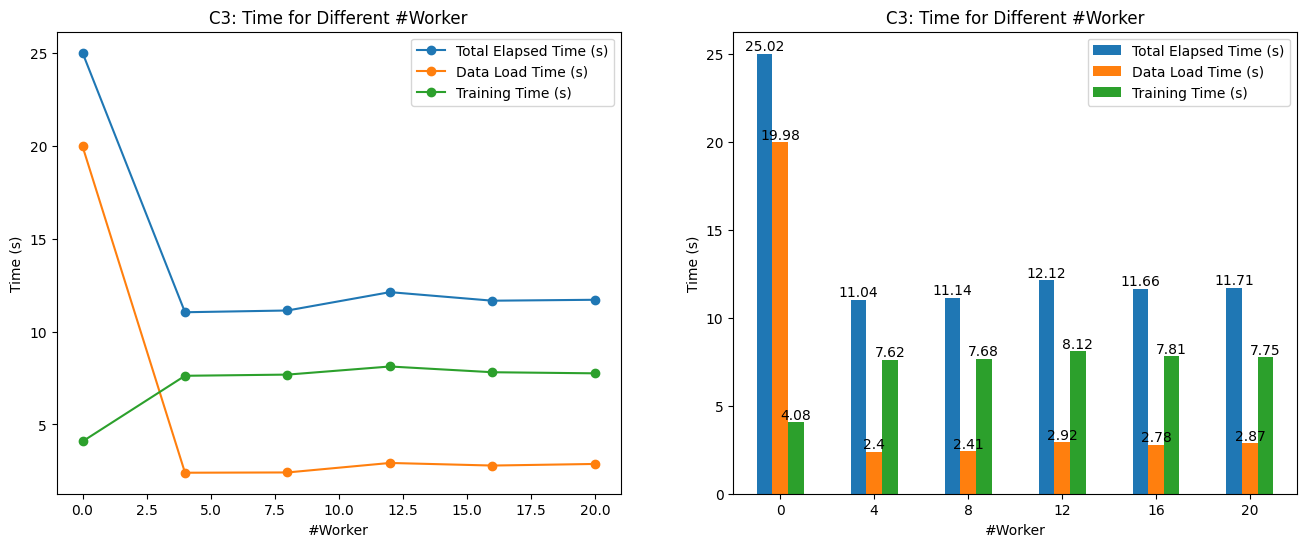

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.subplot(1, 2, 1)
df3.groupby('Worker')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='line', marker='o', ax=ax[0])
plt.ylabel('Time (s)')
plt.xlabel('#Worker')
plt.title('C3: Time for Different #Worker')

plt.subplot(1, 2, 2)
df3.groupby('Worker')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar', ax=ax[1])
plt.ylabel('Time (s)')
plt.xlabel('#Worker')
plt.title('C3: Time for Different #Worker')
plt.xticks(rotation=0)

for p in ax[1].patches:
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')
plt.show()

The best runtime performance is achieved when the number of workers is 4. The runtime performance for data loading is not improved when the number of workers is greater than 4. The runtime performance is the same as the number of workers is 4. Therefore, the best number of workers is 4.

The is optimal value equals to the count of CPU cores. 

### C4: Profiling starting from code in C3
<img src="img/C4.png" align="center"/>

In [7]:
baseline = df3[df3['Worker'] == 4]
baseline.shape

(5, 11)

In [8]:
df4 = parse_log("C4.log")
df4.shape

(5, 11)

In [9]:
df4 = pd.concat([df4, baseline], ignore_index=True)
df4.shape

(10, 11)

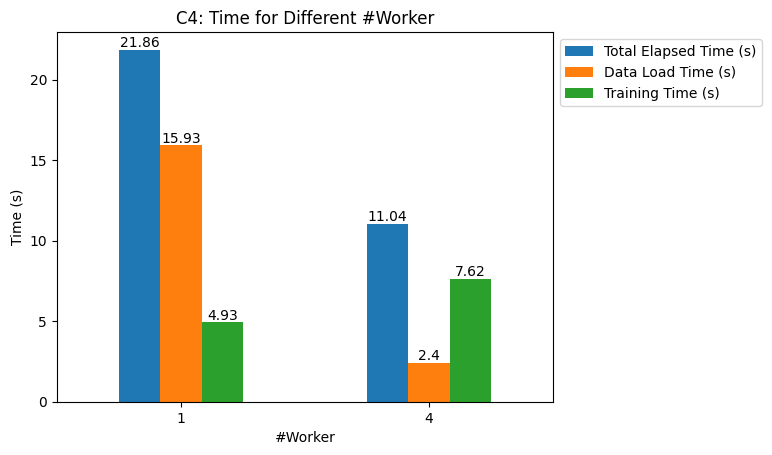

In [10]:
ax = df4.groupby('Worker')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar')
plt.ylabel('Time (s)')
plt.xlabel('#Worker')
plt.title('C4: Time for Different #Worker')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')
plt.show()

The data-loading time when using 4 workers is shorter than the data-loading time when using 1 worker. 
The computing time for training when using 4 workers is larger than the computing time for training when using 1 worker.
The total time when using 4 workers is shorter than the total time when using 1 worker.

**Reason:** Using multiple workers can speed up data loading by parallelizing the task across different processors, reducing wait times as each worker handles a part of the dataset. However, this can lead to increased computing times due to the overhead from managing communication between workers, resource contention when sharing hardware like CPUs or GPUs. In this case, the benefits of parallelizing data loading outweigh the increased computing time, resulting in a shorter total time when using 4 workers compared to 1 worker. 

### C5: Training in GPUs vs CPUs
<img src="img/C3-2.png" align="center"/>
<img src="img/C5.png" align="center"/>

In [11]:
df5 = parse_log("C5.log")
df5.shape

(5, 11)

In [12]:
df5 = pd.concat([df5, baseline], ignore_index=True)
df5.shape

(10, 11)

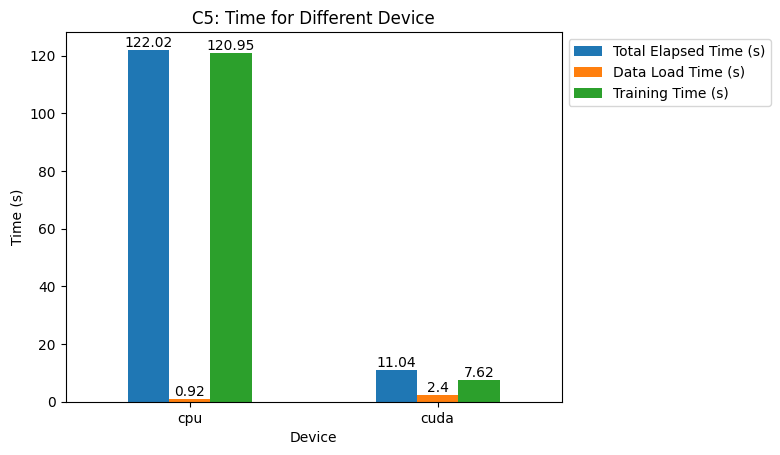

In [13]:
ax = df5.groupby('Device')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar')
plt.ylabel('Time (s)')
plt.xlabel('Device')
plt.title('C5: Time for Different Device')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')
plt.show()

The running time for training using the GPU is much shorter than the running time for training using the CPU. 

### C6: Experimenting with different optimizers
<img src="img/C6-1.png" align="center"/>
<img src="img/C6-2.png" align="center"/>
<img src="img/C6-3.png" align="center"/>
<img src="img/C6-4.png" align="center"/>
<img src="img/C6-5.png" align="center"/>

In [14]:
df6 = parse_log("C6.log")
df6.shape

(25, 11)

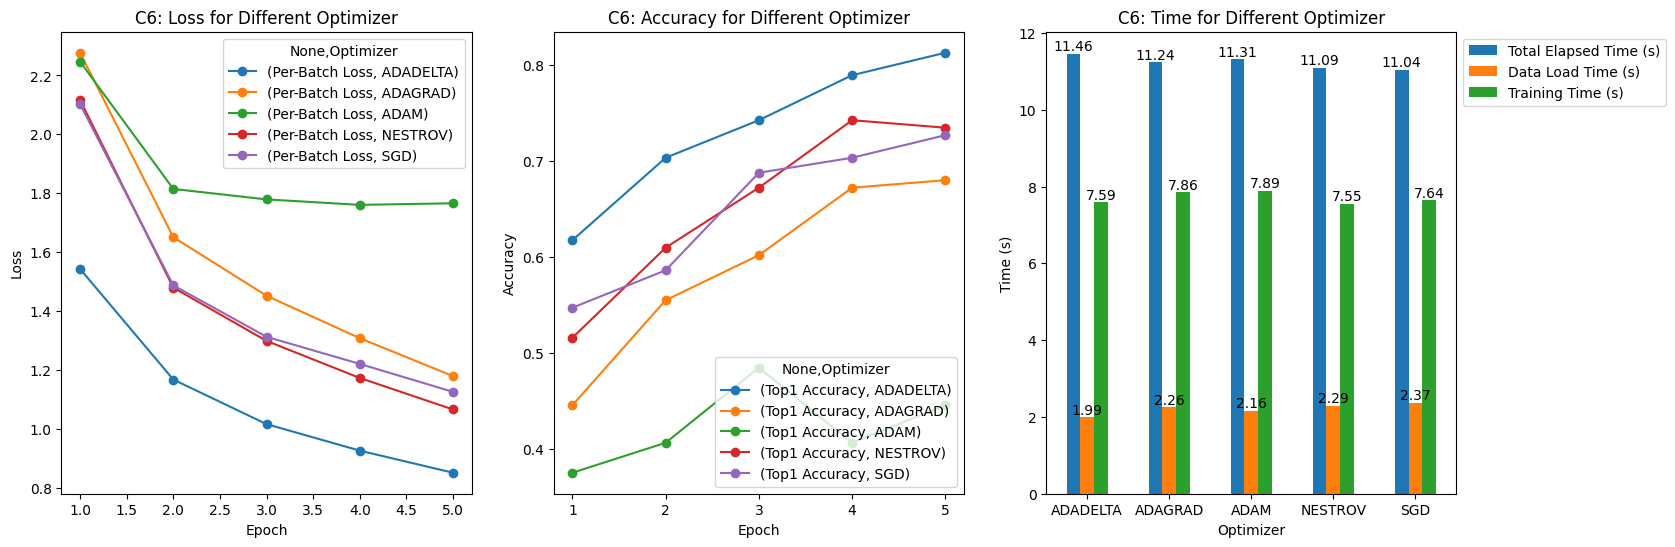

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplot(1, 3, 1)
df6.groupby(['Epoch', 'Optimizer'])[['Per-Batch Loss']].mean().unstack().plot(kind='line', marker='o', ax=ax[0])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('C6: Loss for Different Optimizer')
plt.xticks(rotation=0)
# plt.legend(['AdaDelta', 'Adagrad', 'Adam', 'Nestrov', 'SGD'])


plt.subplot(1, 3, 2)
df6.groupby(['Epoch', 'Optimizer'])[['Top1 Accuracy']].mean().unstack().plot(kind='line', marker='o', ax=ax[1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('C6: Accuracy for Different Optimizer')
plt.xticks(df5['Epoch'].unique(), rotation=0)
# plt.legend(['AdaDelta', 'Adagrad', 'Adam', 'Nestrov', 'SGD'])


plt.subplot(1, 3, 3)
df6.groupby(['Optimizer'])[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar', ax=ax[2])
plt.ylabel('Time (s)')
plt.xlabel('Optimizer')
plt.title('C6: Time for Different Optimizer')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

for p in ax[2].patches:
    ax[2].text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')

plt.show()

**Loss and Accuracy:**

- **Adadelta** shows the best performance in reducing loss quickly, though its impact on accuracy is less impressive, potentially indicating an overfitting issue. **Adam** follows closely in terms of loss reduction and leads in accuracy improvement, suggesting it balances well between efficiently navigating the optimization landscape and preventing overfitting.
- **Nesterov** and **SGD** show more gradual improvements in both metrics. Nesterov slightly outperforms SGD, likely due to its momentum component helping in escaping local minima or making more informed updates.
- **Adagrad** lags in both metrics, suggesting that its approach to adapting learning rates might not be aggressive enough for the task or dataset used.

**Computational Efficiency:**

- **Adadelta** and **Adam** are more computationally demanding, which is visible from the total training times. Their complex mechanisms for adjusting learning rates might contribute to this increased time.
- **SGD** and **Nesterov** are more time-efficient, making them suitable for scenarios where computational resources are limited.
- Across all optimizers, data load times are consistent, indicating that data handling efficiency is independent of the optimizer choice.

In summary, while **Adam** appears to be a strong contender for achieving high accuracy with considerable efficiency in loss reduction, it does require more computational resources. On the other hand, **Nesterov** and **SGD** offer a good compromise between performance and computational demand.


### C7: Experimenting without Batch Norm
<img src="img/C7.png" align="center"/>

In [16]:
df7 = parse_log("C7.log")

In [17]:
df7 = pd.concat([df7, baseline], ignore_index=True)
df7.shape

(10, 11)

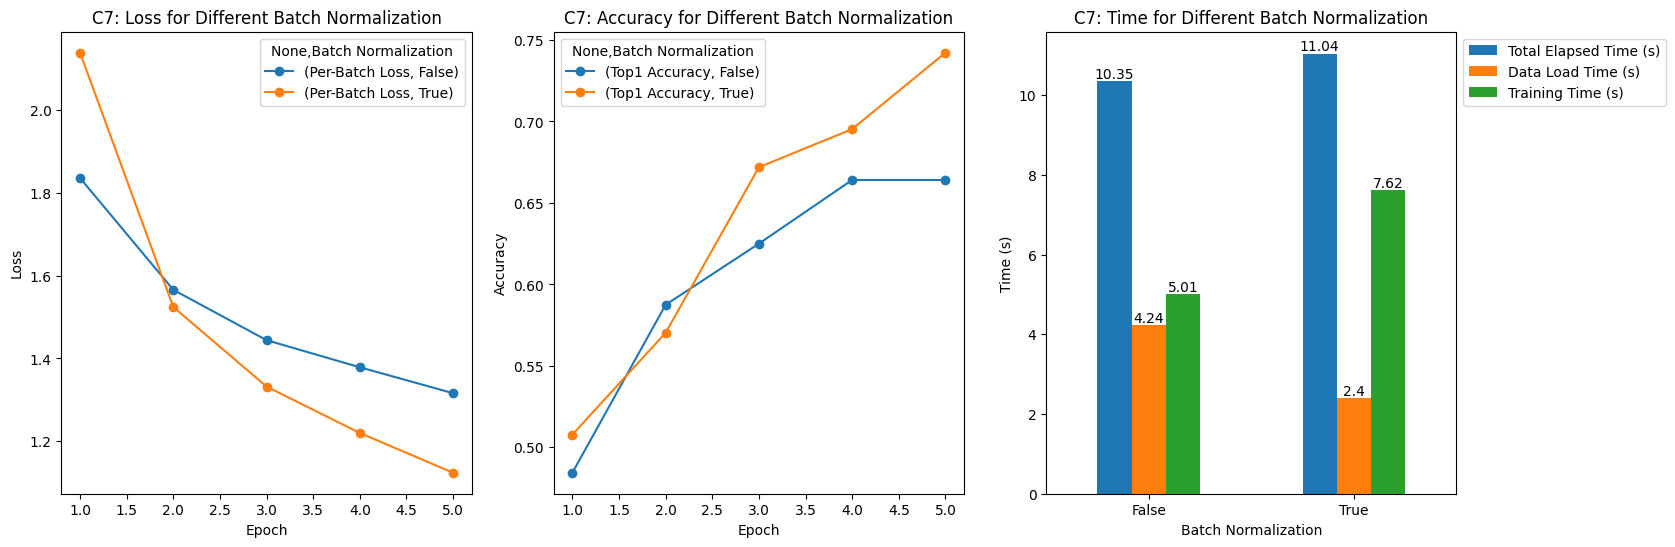

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplot(1, 3, 1)
df7.groupby(['Epoch', 'Batch Normalization'])[['Per-Batch Loss']].mean().unstack().plot(kind='line', marker='o', ax=ax[0])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('C7: Loss for Different Batch Normalization')
plt.xticks(rotation=0)


plt.subplot(1, 3, 2)
df7.groupby(['Epoch', 'Batch Normalization'])[['Top1 Accuracy']].mean().unstack().plot(kind='line', marker='o', ax=ax[1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('C7: Accuracy for Different Batch Normalization')
plt.xticks(rotation=0)


plt.subplot(1, 3, 3)
df7.groupby(['Batch Normalization'])[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar', ax=ax[2])
plt.ylabel('Time (s)')
plt.xlabel('Batch Normalization')
plt.title('C7: Time for Different Batch Normalization')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

for p in ax[2].patches:
    ax[2].text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')
    
plt.show()


Discuss and compare the speed of training with/without batch norm, as well as any effects you notice on convergence.

**Training Speed:**
- **With Batch Normalization:** The training speed is faster with batch normalization, as indicated by the shorter total training time. Batch normalization helps stabilize and accelerate training by normalizing the input to each layer, reducing internal covariate shift and enabling higher learning rates. This leads to faster convergence and shorter training times.
- **Without Batch Normalization:** The training speed is slower without batch normalization, as the model takes longer to converge. The lack of normalization can lead to issues like vanishing or exploding gradients, slowing down training and requiring more iterations to reach convergence.

**Convergence:**
- **With Batch Normalization:** The model converges faster and more consistently with batch normalization. The loss decreases steadily, and the accuracy improves quickly, indicating that the model is learning effectively and efficiently.
- **Without Batch Normalization:** The model converges slower and less smoothly without batch normalization. The loss reduction is slower, and the accuracy improvements are less consistent, suggesting that the model struggles to learn and generalize effectively.

### C8: Accelerate with torch.compile

<img src="img/C8-1.png" align="center"/>
<img src="img/C8-2.png" align="center"/>
<img src="img/C8-3.png" align="center"/>
<img src="img/C8-4.png" align="center"/>



In [19]:
df8 = parse_log("C8.log")
df8.shape

(40, 11)

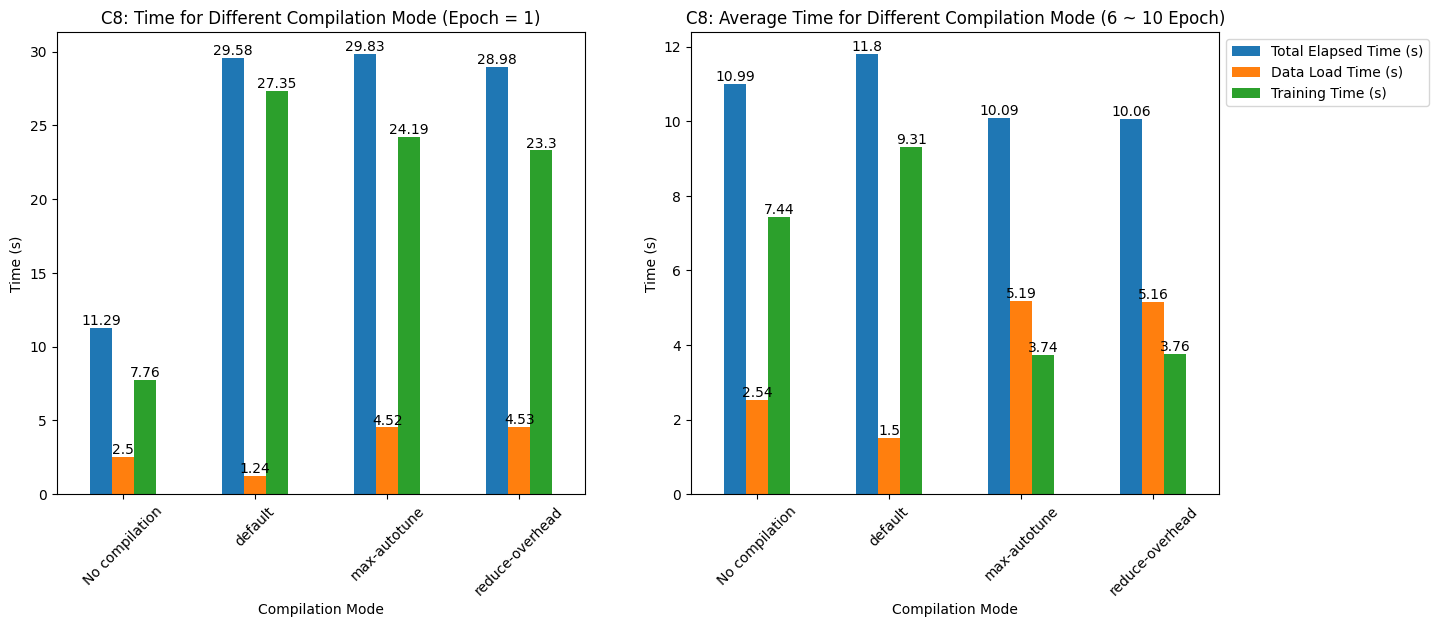

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(1, 2, 1)
df8.query('Epoch == 1').groupby('Compilation Mode')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar', title='C8: Time for Different Compilation Mode (Epoch = 1)', ax=ax[0], legend=False)
plt.ylabel('Time (s)')
plt.xlabel('Compilation Mode')
plt.xticks(rotation=45)

for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')

plt.subplot(1, 2, 2)
df8.query('Epoch >= 6 and Epoch <= 10').groupby('Compilation Mode')[['Total Elapsed Time (s)', 'Data Load Time (s)', 'Training Time (s)']].mean()\
    .plot(kind='bar', title='C8: Average Time for Different Compilation Mode (6 ~ 10 Epoch)', ax=ax[1])
plt.ylabel('Time (s)')
plt.xlabel('Compilation Mode')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

for p in ax[1].patches:
    ax[1].text(p.get_x() + p.get_width() / 2., p.get_height(), np.round(p.get_height(), 2),
            ha='center', va='bottom')

plt.show()

Training time table: 

|                                | Non Compile | Torch.Compile |  Torch.Compile  | Torch.Compile |
| :----------------------------: | :---------: | :-----------: | :-------------: | :-----------: |
|                                | Eager Mode  |    Default    | reduce-overhead | max-autotune  |
|      Time for first epoch      |             |               |                 |               |
| Average time for epochs (6∼10) |             |               |                 |               |

### Q1 
How many convolutional layers are in the ResNet-18 model?
Each block has 2 convolutional layers, thus: $2 \text{ convolutions/block} \times 2 \text{ blocks/layer} \times 4 \text{ layers} = 16 \text{ convolutional layers}$

Additionally, there is an initial convolutional layer (`conv1`) at the start of the model. Therefore, the total number of convolutional layers in the ResNet-18 model is: $16 \text{ (from blocks)} + 1 \text{ (initial layer)} = 17 \text{ convolutional layers}$


### Q2 
What is the input dimension of the last linear layer?

The input dimension of the last linear layer (`fc`) is 512, as the final set of convolutional layers (in `layer4`) outputs 512 channels. This is followed by an adaptive average pooling layer that reduces the spatial dimension to $1 \times 1$, but retains the depth of 512, which directly feeds into the linear layer.

### Q3
How many trainable parameters and how many gradients in the ResNet-18 model that
you build (please show both the answer and the code that you use to count them), when
using SGD optimizer?

In [21]:
import torch
from model import ResNet18
model = ResNet18()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainable_params)

input = torch.randn(1, 3, 224, 224)  # A dummy input image tensor (batch size = 1, channels = 3, height = 224, width = 224)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Using SGD optimizer
criterion = torch.nn.CrossEntropyLoss()  # Loss function

outputs = model(input)
target = torch.tensor([0])  # Dummy target
loss = criterion(outputs, target)
loss.backward()

gradient_count = sum(p.grad.numel() for p in model.parameters() if p.grad is not None)
print("Number of gradients after one backward pass:", gradient_count)

Number of trainable parameters: 11173962
Number of gradients after one backward pass: 11173962


### Q4 
Same question as Q3, except now using Adam (only the answer is required, not the code).

In [22]:
model = ResNet18()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainable_params)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
outputs = model(input)
loss = criterion(outputs, target)
loss.backward()

gradient_count = sum(p.grad.numel() for p in model.parameters() if p.grad is not None)
print("Number of gradients after one backward pass:", gradient_count)

Number of trainable parameters: 11173962
Number of gradients after one backward pass: 11173962


### Q5 
1) What effect does torch.compile have, 
2) how does it make implementations faster and
3) why is the first epoch significantly slower in torch.compile compared to eager mode?

Answers:
1) torch.compile appears to optimize the execution of PyTorch models by compiling the computational graph ahead of time, rather than interpreting it on-the-fly as in eager mode. This compilation process can improve runtime performance by optimizing the execution paths and potentially taking advantage of hardware acceleration features.

2) In the benchmark result above, we see that max_autotune and reduce_overhead compilation modes result in lower total elapsed times compared to both 'no compilation' (eager mode) and the default compilation. This indicates that torch.compile can make implementations faster by reducing the overhead of certain operations and fine-tuning performance to the specific characteristics of the underlying hardware, like processor and memory utilization efficiencies.

3) The first epoch in torch.compile modes, particularly max_autotune and reduce_overhead, shows significantly slower performance due to the initial overhead of the compilation process. During the first epoch, torch.compile analyzes the computational graph, optimizes it for performance (which might involve exploring multiple execution paths), and compiles it down to a form that can be executed more efficiently on the hardware. This initial setup time is a one-time cost that leads to gains in the subsequent epochs, as evident from the lower times in later averages compared to the no compilation mode.

### Extra Credit
